In [18]:
import wandb
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

In [19]:
util_path = "/Users/nasib/code/instant-ngp/scripts"
sys.path.append(util_path)

from common import *
from scenes import *
from utils import *

In [20]:
sweep_id = "p8ccfymd"
sweep_name = "sweep-pca-study"
api = wandb.Api()

In [21]:
# runs = api.runs("inrcompression/instantNGP-4-Compression", filters={"tags": {"$in": ["sweep"], "$in": ["pca-study"]}})
# data = get_df_runs(runs)

csv_path = "/Users/nasib/code/instant-ngp/data/pca_sweep.csv"
data = pd.read_csv(csv_path)

In [22]:
# save_path = "/Users/nasib/code/instant-ngp/data/pca_sweep.csv"
# data.to_csv(save_path, index=False)

In [23]:
data

,run_name,n_levels,base_resolution,log2_hashmap_size,per_level_scale,n_features_per_level,n_enc_params,n_params,loss,psnr,estimated_bpp,psnr_yield_per_param
0,kodim11,15,203,4,1.8,2,480,7648,-1.558661,15.586613,0.155599,0.032472
1,kodim11,6,256,15,1.9,4,786432,793600,-4.504335,45.043352,16.145833,0.000057
2,kodim11,11,62,13,1.7,2,171536,178704,-3.508976,35.089764,3.635742,0.000205
3,kodim11,14,82,14,1.3,4,859168,868384,-5.120584,51.205837,17.667318,0.000060
4,kodim11,11,82,11,1.2,4,90112,98304,-3.095000,30.949997,2.000000,0.000343
...,...,...,...,...,...,...,...,...,...,...,...,...
188,kodim11,2,177,16,1.6,8,774976,781120,-5.030032,50.300320,15.891927,0.000065
189,kodim11,5,250,5,1.7,2,320,6464,-1.551708,15.517076,0.131510,0.048491
190,kodim11,5,46,16,1.6,4,491168,498336,-4.631759,46.317587,10.138672,0.000094
191,kodim11,6,161,10,1.1,8,49152,57344,-2.454018,24.540181,1.166667,0.000499


In [24]:
X = data.drop(
    [
        "psnr",
        "loss",
        "n_enc_params",
        "n_params",
        "estimated_bpp",
        "psnr_yield_per_param",
        "run_name",
    ],
    axis=1,
)  # Hyperparameters

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = data["psnr"]  # Target variable (PSNR)

# Assume X contains hyperparameters and y contains PSNR values
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

### Linear Regression, Elastic-Net and ...

In [25]:
# Initialize, train, and test the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Initialize, train, and test the elastic-net model
elastic_net_model = ElasticNet(
    alpha=1.0, l1_ratio=0.5
)  # Adjust alpha and l1_ratio as needed
elastic_net_model.fit(X_train, y_train)
y_pred_elastic_net = elastic_net_model.predict(X_test)

# Evaluate the model using Mean Squared Error
linear_mse = mean_squared_error(y_test, y_pred_linear)
elastic_mse = mean_squared_error(y_test, y_pred_elastic_net)

# Print the coefficients to understand the impact of each hyperparameter
print(
    "Linear Inter:\t",
    linear_model.intercept_,
    "\tElastic Inter:\t",
    elastic_net_model.intercept_,
)
print("Linear MSE:\t", linear_mse, "\tElastic MSE:\t", elastic_mse)

# Assuming 'hyperparameter_names' contains the names of your hyperparameters
hyperparameter_names = X.columns.tolist()

# Assuming 'reg_model' is your trained regression model
linear_coefficients = linear_model.coef_
elastic_coefficients = elastic_net_model.coef_
print("Linear coefficients:\t", linear_coefficients, "\nElastic coefficients:\t", elastic_coefficients)

Linear Inter:	 29.306157868871583 	Elastic Inter:	 29.50494288052777
Linear MSE:	 68.92351518113716 	Elastic MSE:	 69.21886912124921
Linear coefficients:	 [ 3.15868815 -1.51703024 13.59980984 -0.76529865  2.3269381 ] 
Elastic coefficients:	 [ 1.84140944 -0.69164724  8.74355776 -0.06377635  1.26265963]


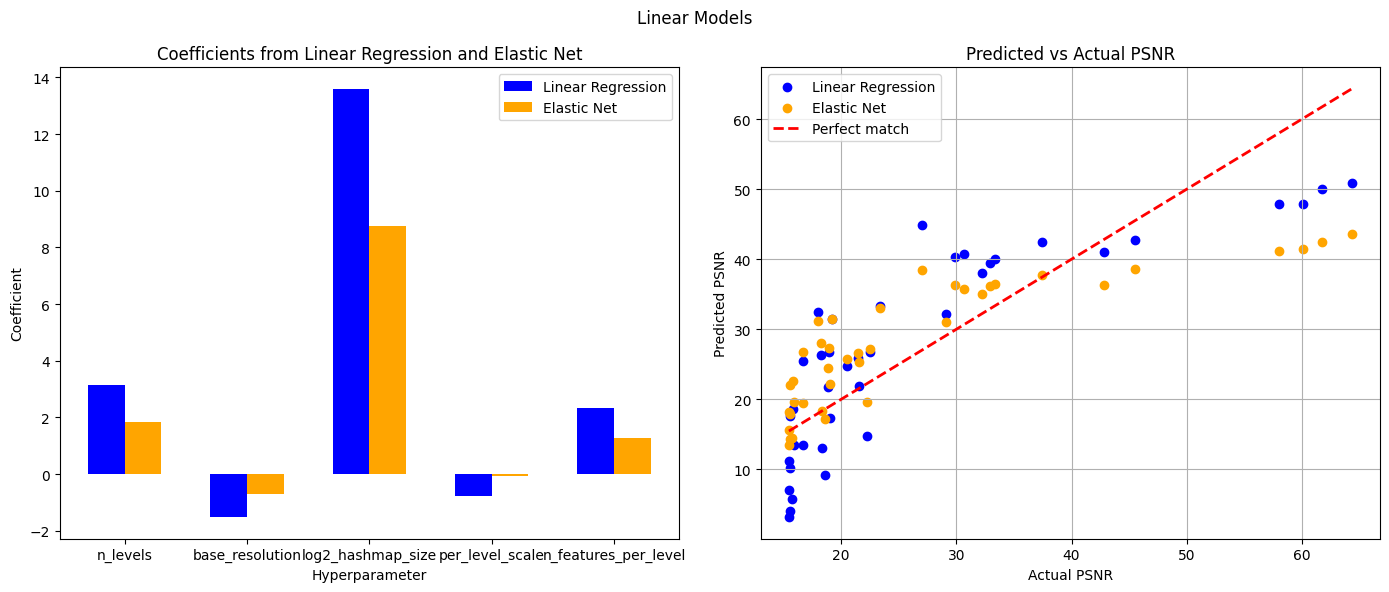

In [27]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Linear Models")

# Width of a bar
bar_width = 0.3
ind = np.arange(len(hyperparameter_names))

# Plot feature importances
axes[0].bar(
    ind, linear_coefficients, bar_width, label="Linear Regression", color="blue"
)
axes[0].bar(
    ind + bar_width,
    elastic_coefficients,
    bar_width,
    label="Elastic Net",
    color="orange",
)
axes[0].set_xlabel("Hyperparameter")
axes[0].set_ylabel("Coefficient")
axes[0].set_title("Coefficients from Linear Regression and Elastic Net")
axes[0].set_xticks(ind + bar_width / 2, hyperparameter_names)
axes[0].legend()

# Plot predicted vs actual PSNR
axes[1].scatter(y_test, y_pred_linear, color="blue", label="Linear Regression")
axes[1].scatter(y_test, y_pred_elastic_net, color="orange", label="Elastic Net")
axes[1].plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Perfect match",
)
axes[1].set_xlabel("Actual PSNR")
axes[1].set_ylabel("Predicted PSNR")
axes[1].set_title("Predicted vs Actual PSNR")
axes[1].grid()
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Kernel Models: Support Vector Regression, Kernel Ridge, ...

In [30]:
kernel_choice = 'rbf' # ['linear', 'poly', 'rbf', 'sigmoid']

# SVR model
svr_model = SVR(kernel=kernel_choice, degree=3, C=1.0)
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# Kernel Ridge Regression model
kernel_ridge_model = KernelRidge(kernel=kernel_choice, alpha=0.1)  # You can experiment with different kernels and hyperparameters
kernel_ridge_model.fit(X_train, y_train)
y_pred_kernel_ridge = kernel_ridge_model.predict(X_test)

# MSE
mse_svr = mean_squared_error(y_test, y_pred_svr)
mse_kernel_ridge = mean_squared_error(y_test, y_pred_kernel_ridge)
print("SVR Model MSE:\t\t", mse_svr, "\nKernel Ridge Model MSE:\t", mse_kernel_ridge)

# Calculate permutation feature importance
perm_importance_svr = permutation_importance(svr_model, X_test, y_test, n_repeats=30, random_state=42)
perm_importance_kernel_ridge = permutation_importance(kernel_ridge_model, X_test, y_test, n_repeats=30, random_state=42)


SVR Model MSE:		 101.74401452011328 
Kernel Ridge Model MSE:	 14.95637102494631


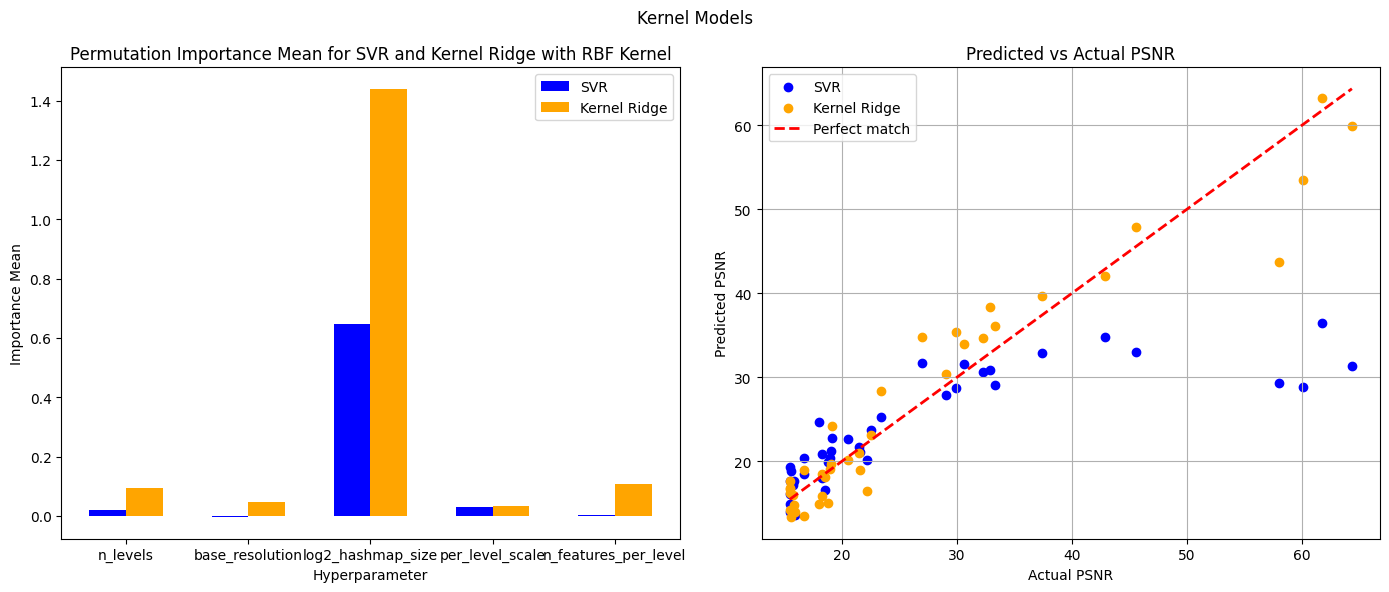

In [32]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Models")

# Width of a bar
bar_width = 0.3
ind = np.arange(len(hyperparameter_names))

# Plot feature importances
axes[0].bar(
    ind, perm_importance_svr['importances_mean'], bar_width, label="SVR", color="blue"
)
axes[0].bar(
    ind + bar_width,
    perm_importance_kernel_ridge['importances_mean'],
    bar_width,
    label="Kernel Ridge",
    color="orange",
)
axes[0].set_xlabel("Hyperparameter")
axes[0].set_ylabel("Importance Mean")
axes[0].set_title("Permutation Importance Mean for SVR and Kernel Ridge with RBF Kernel")
axes[0].set_xticks(ind + bar_width / 2, hyperparameter_names)
axes[0].legend()

# Plot predicted vs actual PSNR
axes[1].scatter(y_test, y_pred_svr, color="blue", label="SVR")
axes[1].scatter(y_test, y_pred_kernel_ridge, color="orange", label="Kernel Ridge")
axes[1].plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Perfect match",
)
axes[1].set_xlabel("Actual PSNR")
axes[1].set_ylabel("Predicted PSNR")
axes[1].set_title("Predicted vs Actual PSNR")
axes[1].grid()
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Gradient Boosting 

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Create the XGBRegressor model with n_estimators
xgbr_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression task
    max_depth=5,  # Maximum depth of trees
    learning_rate=0.1,  # Learning rate
    n_estimators=100  # Number of boosting rounds
)

# Train the XGBoost model
xgbr_model.fit(X_train, y_train)

# Make predictions
y_pred_xgbr = xgbr_model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred_xgbr)
print("XGBoost Model MSE:", mse)

feature_importances = xgbr_model.feature_importances_

XGBoost Model MSE: 13.60511843554897


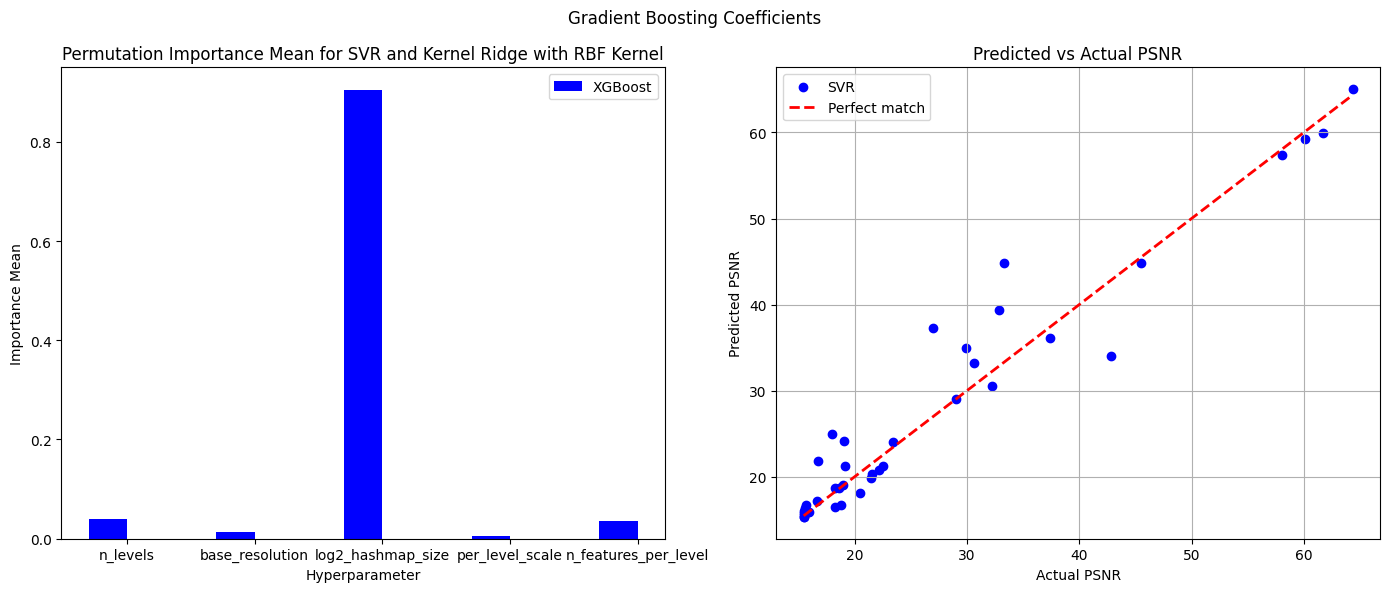

In [35]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Gradient Boosting Coefficients")

# Width of a bar
bar_width = 0.3
ind = np.arange(len(hyperparameter_names))

# Plot feature importances
axes[0].bar(ind, feature_importances, bar_width, label="XGBoost", color="blue")
# axes[0].bar(
#     ind + bar_width,
#     perm_importance_kernel_ridge['importances_mean'],
#     bar_width,
#     label="Kernel Ridge",
#     color="orange",
# )
axes[0].set_xlabel("Hyperparameter")
axes[0].set_ylabel("Importance Mean")
axes[0].set_title(
    "Permutation Importance Mean for SVR and Kernel Ridge with RBF Kernel"
)
axes[0].set_xticks(ind + bar_width / 2, hyperparameter_names)
axes[0].legend()

# Plot predicted vs actual PSNR
axes[1].scatter(y_test, y_pred_xgbr, color="blue", label="SVR")
# axes[1].scatter(y_test, y_pred_kernel_ridge, color="orange", label="Kernel Ridge")
axes[1].plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Perfect match",
)
axes[1].set_xlabel("Actual PSNR")
axes[1].set_ylabel("Predicted PSNR")
axes[1].set_title("Predicted vs Actual PSNR")
axes[1].grid()
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

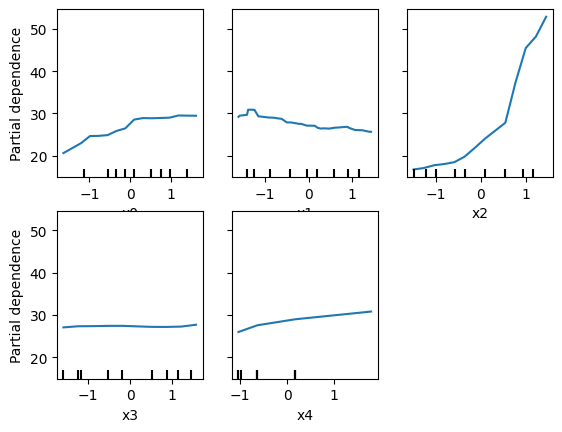

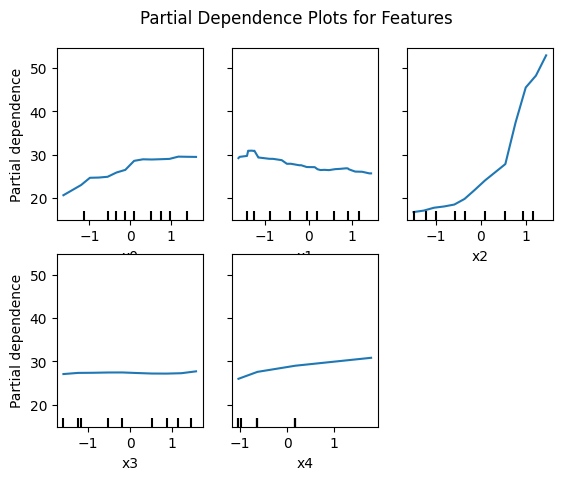

In [43]:
from sklearn.inspection import PartialDependenceDisplay

disp = PartialDependenceDisplay.from_estimator(
    estimator=xgbr_model, X=X_test, features=[0, 1, 2, 3, 4], grid_resolution=50
)
disp.plot()
plt.suptitle('Partial Dependence Plots for Features')
plt.subplots_adjust(top=0.9)

plt.show()

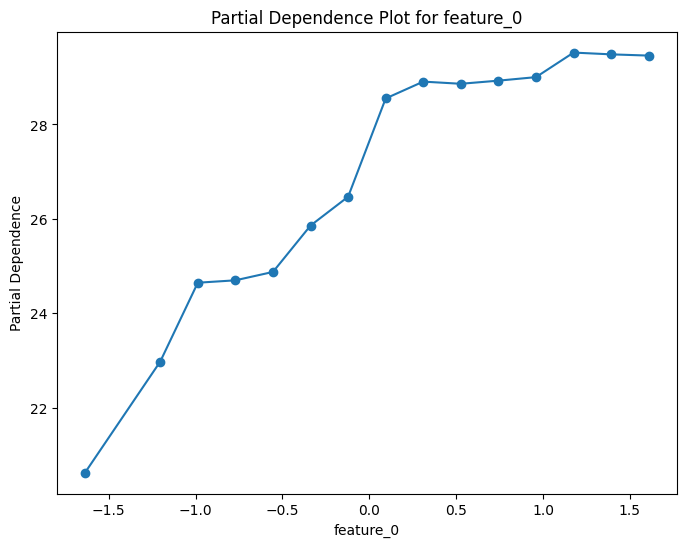

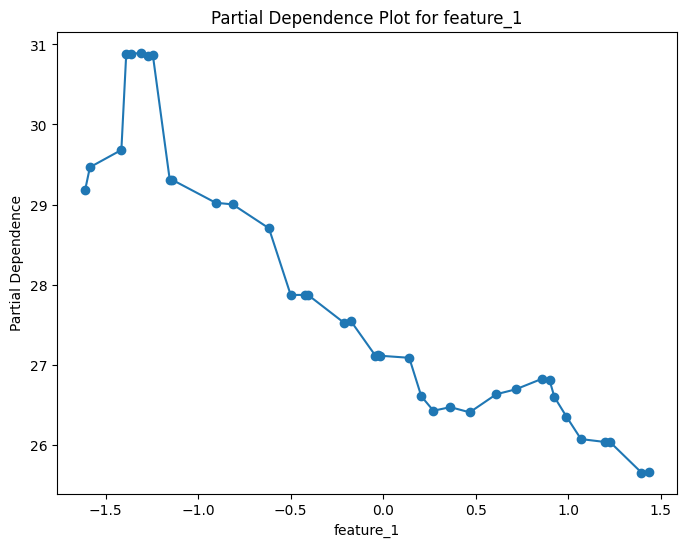

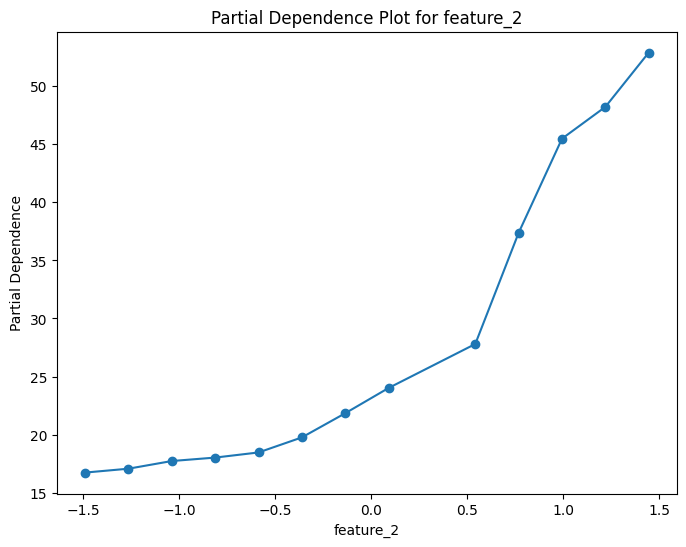

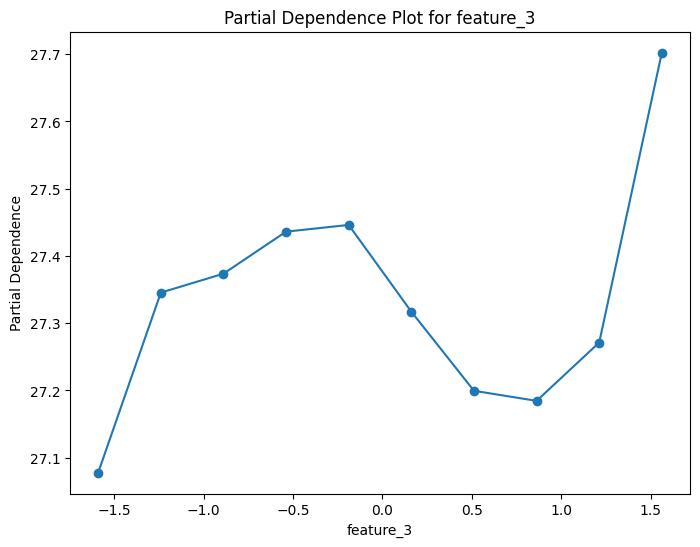

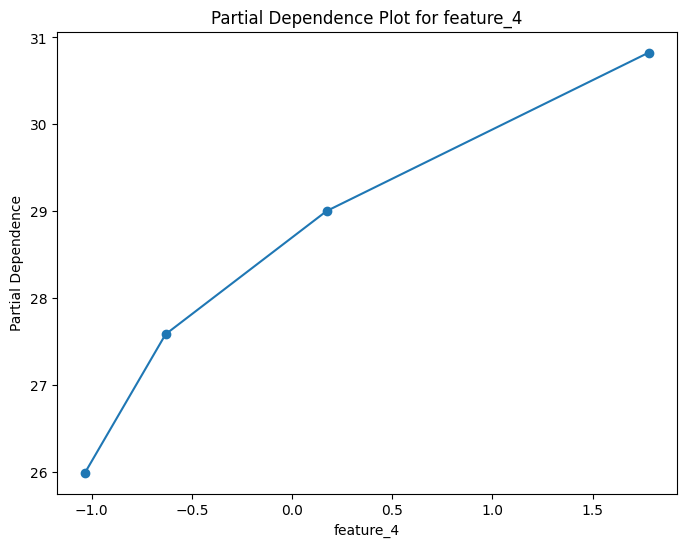

In [70]:
from sklearn.inspection import partial_dependence

# Create partial dependence plots for each feature
feature_names = ['feature_{}'.format(i) for i in range(X_train.shape[1])]
for feature_idx, feature_name in enumerate(feature_names):
    pdp = partial_dependence(xgbr_model, X_test, features=[feature_idx], grid_resolution=50)
    
    plt.figure(figsize=(8, 6))
    plt.plot(pdp.grid_values[0], pdp.average[0], marker='o')  # Reversed indexing for correct plotting
    plt.xlabel(feature_name)
    plt.ylabel('Partial Dependence')
    plt.title('Partial Dependence Plot for {}'.format(feature_name))
    plt.show()

In [ ]:
# from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import plot_partial_dependence

# Create PDPs for the first few features
features_to_plot = [0, 1, 2]  # Replace with the feature indices you want to plot
plot_partial_dependence(model, X_test, features=features_to_plot)
plt.suptitle('Partial Dependence Plots from XGBoost')
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
import shap

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Create a LIME explainer
explainer = LimeTabularExplainer(X_train, mode='regression')

# Explain a specific prediction using LIME
prediction_index = 0  # Replace with the index of the prediction you want to explain
explanation = explainer.explain_instance(X_test[prediction_index], model.predict)
explanation.show_in_notebook()
